# Image Localization #

<b > About Dataset </b> \
Context
Including images and its corresponding .xml files. Before drawing bounding boxes, all images were resized to (227,227,3).

There is only one type of object in each picture.

# Imports lib

In [29]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import xml.etree.ElementTree as xt
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px

from PIL import Image
from skimage import io
from glob import glob
from tensorflow.keras.models import Model
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten

# Data Preprocessing

In [30]:
# get a file xml to looking
paths = "/content/data/"
xml_example = paths+'mushroom_59.xml'

with open(xml_example, 'r') as f:
    data = f.read()
    content = BeautifulSoup(data, 'xml')
content

<?xml version="1.0" encoding="utf-8"?>
<annotation>
<folder>single mushroom</folder>
<filename>mushroom_59.jpg</filename>
<path>C:\Users\Muhammed Buyukkinaci\Downloads\single mushroom\mushroom_59.jpg</path>
<source>
<database>Unknown</database>
</source>
<size>
<width>227</width>
<height>227</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>mushroom</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>93</xmin>
<ymin>69</ymin>
<xmax>177</xmax>
<ymax>203</ymax>
</bndbox>
</object>
</annotation>

In [31]:
# Parsing XML and getting the Labels
path = sorted(glob(f'{paths}*.xml'))# get all elements in path with xml extension
y = [] #create a list to store our targets
for file in path:# loop over each file path and parse it
    label = 0
    info = xt.parse(file) 
    root = info.getroot() 
    obj = root.find('object')
    
    label_obj = (obj.find('name').text)
    if "cucumber" in label_obj:  
        label = 1
    elif "eggplant" in label_obj:
        label = 2
    elif "mushroom" in label_obj:
        label = 3

    bndbox = obj.find('bndbox')
    xmin = (bndbox.find('xmin').text)
    xmax = (bndbox.find('xmax').text)
    ymin = (bndbox.find('ymin').text)
    ymax = (bndbox.find('ymax').text)
    
    #append the results to our target
    y.append([int(label),int(xmin),int(ymin),int(xmax),int(ymax)])

In [32]:
# Reading Images
X = []
images_path = sorted(glob(f'{paths}*.jpg'))# get all elements in path with jpg extension

for image in images_path:#loop over image path
    img = cv2.imread(image, cv2.COLOR_BGR2RGB)# read the image in rgb mode
    X.append(img)

In [33]:
img_example = X[0]
bbox = y[0][1:]
y[1][1:] #view the bbox coordinates

[13, 70, 219, 160]


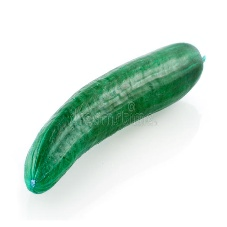

In [34]:
fig = px.imshow(img_example)
fig.update_layout(width=800, height=600, margin=dict(l=10, r=10, b=10, t=10))
fig.add_shape(type='rect',x0=bbox[0], x1=bbox[2], y0=bbox[1], y1=bbox[3], xref='x', yref='y',line_color='cyan')

In [35]:
X = np.array(X)
y =  np.array(y)
X.shape , y.shape

((186, 227, 227, 3), (186, 5))

In [36]:
# split  base data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [37]:
# the bbox coordinates and the category so let's split the labels
categ_train = y_train[:,0:1]
categ_test = y_test[:,0:1]
bbox_train = y_train[:,1:]
bbox_test = y_test[:,1:]
categ_train.shape,categ_test.shape,bbox_train.shape,bbox_test.shape

((148, 1), (38, 1), (148, 4), (38, 4))

In [38]:
# one hot 
categ_train = tf.keras.utils.to_categorical(categ_train)
categ_test = tf.keras.utils.to_categorical(categ_test)

# Modeling

In [39]:
#Load InceptionV3
inception = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(227,227,3))
inception.trainable = True #Set layers to trainable

last_layer = inception.get_layer('mixed10') #get last layer in inception

print('last layer output shape: ', last_layer.output_shape)

layer_output = last_layer.output

87910968/87910968 [==============================] - 0s 0us/step
last layer output shape:  (None, 5, 5, 2048)


In [40]:
# add head layers
x = Flatten()(layer_output)
x1 = Dropout(0.3)(x)
x2 = Dense(4112,activation="relu")(x1)
drop1 = Dropout(0.3)(x2)
x3 = Dense(1028,activation="relu")(x2)
x4 = Dense(1028,activation="relu")(x3)
drop1 = Dropout(0.5)(x4)

x5 = Dense(256,activation="relu")(drop1)
drop2 = Dropout(0.3)(x5)
classification_output = Dense(4,activation='softmax',name = 'classification')(x2)
bounding_box_output = Dense(4,name = 'bounding_box')(x5)
model = tf.keras.Model(inputs = inception.inputs, outputs = [classification_output, bounding_box_output])

In [41]:
# LR decay
def scheduler(epoch, lr):
    """
    Applies exponential decay
    Args:
    epoch: Epoch to start the decay at
    lr: current learning rate
    """
    if epoch < 40:
        return lr
    else:
        return lr * tf.math.exp(-0.12)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [42]:
  model.compile(optimizer=Adam(learning_rate=1e-4),
              loss = {'classification' : 'categorical_crossentropy',
                      'bounding_box' : 'mse'
                     },
              metrics = {'classification' : 'accuracy',
                         'bounding_box' : 'mse'
                        })

In [43]:
resul= model.fit(X_train,[categ_train,bbox_train],epochs=70,validation_data=(X_test,[categ_test,bbox_test]),callbacks=[callback])

Epoch 1/70
5/5 [==============================] - 69s 2s/step - loss: 16456.2559 - classification_loss: 1.4284 - bounding_box_loss: 16454.8301 - classification_accuracy: 0.2973 - bounding_box_mse: 16454.8301 - val_loss: 3362.7229 - val_classification_loss: 1.5038 - val_bounding_box_loss: 3361.2192 - val_classification_accuracy: 0.3158 - val_bounding_box_mse: 3361.2192 - lr: 1.0000e-04
Epoch 2/70
5/5 [==============================] - 1s 273ms/step - loss: 4324.7397 - classification_loss: 1.2641 - bounding_box_loss: 4323.4756 - classification_accuracy: 0.3851 - bounding_box_mse: 4323.4756 - val_loss: 23216.7031 - val_classification_loss: 2.5023 - val_bounding_box_loss: 23214.2012 - val_classification_accuracy: 0.3947 - val_bounding_box_mse: 23214.2012 - lr: 1.0000e-04
Epoch 3/70
5/5 [==============================] - 1s 273ms/step - loss: 3529.3269 - classification_loss: 1.4313 - bounding_box_loss: 3527.8958 - classification_accuracy: 0.4122 - bounding_box_mse: 3527.8958 - val_loss: 670

In [44]:
# using pandas to looking history train
results = pd.DataFrame(resul.history)
results.tail()

,loss,classification_loss,bounding_box_loss,classification_accuracy,bounding_box_mse,val_loss,val_classification_loss,val_bounding_box_loss,val_classification_accuracy,val_bounding_box_mse,lr
65,159.307938,0.062678,159.245270,1.0,159.245270,288.283356,0.206234,288.077118,0.947368,288.077118,0.000004
66,154.850983,0.062597,154.788376,1.0,154.788376,285.781830,0.207018,285.574829,0.947368,285.574829,0.000004
67,172.078735,0.054940,172.023773,1.0,172.023788,285.263458,0.208225,285.055267,0.947368,285.055267,0.000003
68,170.886337,0.053351,170.832977,1.0,170.832977,284.160553,0.208135,283.952423,0.947368,283.952423,0.000003
69,162.707504,0.064999,162.642502,1.0,162.642502,280.503235,0.207762,280.295471,0.947368,280.295471,0.000003



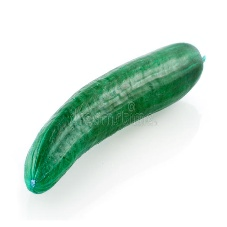

In [45]:
# visua for loss of training
ig = px.line(results,y=[results['classification_loss'],results['val_classification_loss']],template="seaborn",color_discrete_sequence=['#05445E','#75E6DA'])
fig.update_layout(   
    title_font_color="#75E6DA", 
    xaxis=dict(color="#75E6DA",title='Epochs'), 
    yaxis=dict(color="#75E6DA")
 )
fig.show()

In [46]:
# boxes loss
fig = px.line(results,y=[results['bounding_box_loss'],results['val_bounding_box_loss']],template="seaborn",color_discrete_sequence=['#05445E','#75E6DA'])
fig.update_layout(   
    title_font_color="#75E6DA", 
    xaxis=dict(color="#75E6DA",title='Epochs'), 
    yaxis=dict(color="#75E6DA")
 )
fig.show()

In [47]:
# visua acc
fig = px.line(results,y=[results['classification_accuracy'],results['val_classification_accuracy']],template="seaborn",color_discrete_sequence=['#05445E','#75E6DA'])
fig.update_layout(   
    title_font_color="#75E6DA", 
    xaxis=dict(color="#75E6DA",title='Epochs'), 
    yaxis=dict(color="#75E6DA")
 )
fig.show()

# predictions

In [48]:
def predict(path, model, from_url=False):
    """
    passes an image to a trained model and returns annotated image

    Args:
    path:  path containing the image or a list of paths
    model:  pretrained model instance
    from_url: (boolen) to check if the path is a url
    """
    # Check if the path is a list
    if type(path) == list:
        # loop over each path and read the image
        for p in path:
            if from_url:
                image = io.imread(p)
            else:
                image = cv2.imread(p)
    # Check if the type of the path is a string
    elif type(path) == str:
            # read the given image
            if from_url:
                image = io.imread(path)
            else:
                image = cv2.imread(path)
    # Resize the image into the appropriate shape    
    image = cv2.resize(image,(227,227))
    # get model predictions
    categ,bbox = model.predict(np.array([image]))
    # Get class of the highest given probability
    categ = np.argmax(categ)
    # flatten the bounding box array and cast it into integer
    bbox = bbox.flatten()
    bbox = bbox.astype(int)
    # draw a rectangle on the image using the predicted bbox coordinates
    image = cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(255,0,0),1)
    # set prediction class to an empty string
    prediction = ''
    # set the prediction to the name of the given class according to the model's prediction
    if categ == 1:
        prediction = 'Cucumber'
    elif categ == 2:
        prediction = 'Egg Plant'
    elif categ == 3:
        prediction = 'Mushroom'
    # Put the text of the prediction on the image
    final_img = cv2.putText(image,prediction,(bbox[0],bbox[1]-4),cv2.FONT_HERSHEY_SIMPLEX,0.3,(255,0,0),1,255)
    # Plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(final_img)
    plt.axis('off')
    plt.show()

In [49]:
# for i in range(40,46):
#     paths = []
#     paths.append(f'/eggplant_{i}.jpg')
#     predict(paths,model,False)

1/1 [==============================] - 2s 2s/step


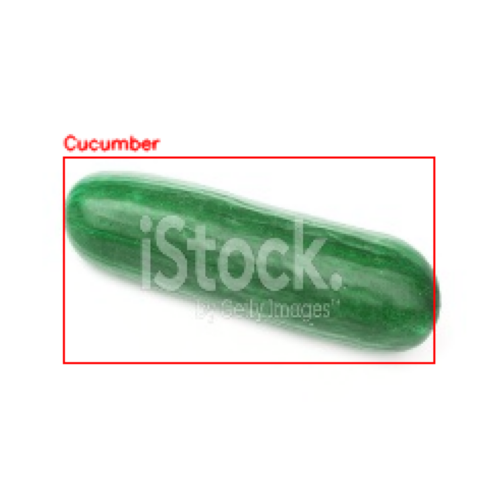

In [51]:
predict(paths + 'cucumber_37.jpg',model)